In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/breast-cancer-images-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/benign (265).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/benign (296).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/benign (173).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/benign (96).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/benign (371).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/benign (232).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/malignant (147).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/malignant (208).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/ann/benign (42).png.json
/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset/an

In [2]:
import os
import json
import base64
import zlib
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, losses, metrics, optimizers
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image
import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import image

2025-05-12 13:15:36.315040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747055736.705881      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747055736.825975      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set image size and number of classes
IMG_SIZE = 256
NUM_CLASSES = 3

# Label map
label_map = {
    "benign": 0,
    "malignant": 1,
    "normal": 2
}

In [4]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)
    denominator = tf.reduce_sum(y_true_flat + y_pred_flat, axis=1)
    dice = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - tf.reduce_mean(dice)

In [5]:
# def dice_coef(y_true, y_pred, smooth=1e-6):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)

#     # Clip predictions to avoid zero division or NaNs
#     y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)

#     # Flatten predictions and truth
#     y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
#     y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

#     # Calculate intersection and denominator
#     intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)
#     denominator = tf.reduce_sum(y_true_flat + y_pred_flat, axis=1)

#     # Debugging print: check intersection and denominator
#     print("Intersection:", intersection)
#     print("Denominator:", denominator)

#     # Avoid division by zero
#     dice = (2. * intersection + smooth) / (denominator + smooth)

#     # Debugging print: check final dice score per batch
#     print("Dice:", dice)

#     # Return mean of dice over all samples in batch
#     return tf.reduce_mean(dice)



In [6]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Clip predictions to avoid division by zero or NaNs
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)

    # Flatten predictions and truth
    y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    # Calculate intersection and denominator
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)
    denominator = tf.reduce_sum(y_true_flat + y_pred_flat, axis=1)

    # Ensure Dice coefficient is not NaN
    dice = (2. * intersection + smooth) / (denominator + smooth)

    # Return the average dice coefficient across the batch
    return tf.reduce_mean(dice)


In [7]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * p * r / (p + r + 1e-6)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()



In [8]:
# U-Net conv block
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

# Multitask U-Net
def build_multitask_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(shape=input_shape)
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    bn = conv_block(p4, 1024)

    u1 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(bn)
    u1 = layers.concatenate([u1, c4])
    c5 = conv_block(u1, 512)
    u2 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = conv_block(u2, 256)
    u3 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = conv_block(u3, 128)
    u4 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = conv_block(u4, 64)

    seg_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='seg_output')(c8)
    gap = layers.GlobalAveragePooling2D()(bn)
    dense1 = layers.Dense(128, activation='relu')(gap)
    dropout = layers.Dropout(0.5)(dense1)
    class_output = layers.Dense(NUM_CLASSES, activation='softmax', name='class_output')(dropout)
    model = models.Model(inputs=inputs, outputs={'seg_output': seg_output, 'class_output': class_output})
    return model

In [9]:
# Data generator
class BreastCancerDataset(Sequence):
    def __init__(self, img_dir, ann_dir, batch_size=8, img_size=256, shuffle=True, filenames=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.filenames = filenames or [f for f in os.listdir(self.img_dir) if f.endswith(('.png', '.jpg'))]
        self.on_epoch_end()
        

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))
        

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.filenames)
            

    def __getitem__(self, index):
        batch_files = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]
        X = np.zeros((len(batch_files), self.img_size, self.img_size, 1), dtype=np.float32)
        Y_mask = np.zeros((len(batch_files), self.img_size, self.img_size, 1), dtype=np.float32)
        Y_label = np.zeros((len(batch_files), NUM_CLASSES), dtype=np.float32)

        for i, file in enumerate(batch_files):
            img_path = os.path.join(self.img_dir, file)
            ann_path = os.path.join(self.ann_dir, file + ".json")

            if not os.path.exists(ann_path):
                continue
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = cv2.GaussianBlur(img, (3, 3), 0)
            X[i, ..., 0] = img.astype(np.float32) / 255.0    #Normalize
            Y_mask[i, ..., 0] = self.decode_mask(ann_path)
            label_str = self.get_label_from_json(ann_path)
            Y_label[i, label_map[label_str]] = 1.0

        return X, {"seg_output": Y_mask, "class_output": Y_label}
        

    def decode_mask(self, json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
        size = data['size']
        H, W = size['height'], size['width']
        if not data['objects']:
            return np.zeros((self.img_size, self.img_size), dtype=np.float32)
        obj = data['objects'][0]
        origin_x, origin_y = obj['bitmap']['origin']
        compressed_data = base64.b64decode(obj['bitmap']['data'])
        decompressed = zlib.decompress(compressed_data)
        mask_img = Image.open(io.BytesIO(decompressed)).convert('L')
        mask_np = np.array(mask_img)
        full_mask = np.zeros((H, W), dtype=np.uint8)
        h, w = mask_np.shape
        full_mask[origin_y:origin_y + h, origin_x:origin_x + w] = mask_np
        resized_mask = cv2.resize(full_mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
        return (resized_mask > 127).astype(np.float32)

    
    def get_label_from_json(self, json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
    
        if data.get('objects') and len(data['objects']) > 0:
            return data['objects'][0].get('classTitle', 'normal')
        else:
            return 'normal'  # fallback when no object is annotated


In [10]:
# Prepare dataset
base_path = "/kaggle/input/breast-cancer-images-dataset/breast-ultrasound-images-dataset"
img_dir = os.path.join(base_path, "img")
ann_dir = os.path.join(base_path, "ann")
all_files = [f for f in os.listdir(img_dir) if f.endswith('.png') or f.endswith('.jpg')]
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

train_gen = BreastCancerDataset(img_dir, ann_dir, batch_size=8, img_size=256, filenames=train_files)
val_gen = BreastCancerDataset(img_dir, ann_dir, batch_size=8, img_size=256, shuffle=False, filenames=val_files)

# Compile model
model = build_multitask_unet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={'seg_output': dice_loss, 'class_output': 'categorical_crossentropy'},
    loss_weights={'seg_output': 0.5, 'class_output': 0.5},
    metrics={
        'seg_output': [
            tf.keras.metrics.MeanIoU(num_classes=2),
            tf.keras.metrics.BinaryAccuracy(name='pixel_accuracy'),
            dice_coef  # Make sure this is added in `metrics`
        ],
        'class_output': [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            F1Score()
        ]
    }
)




# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", verbose=1)
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=70,
    callbacks=callbacks
)

I0000 00:00:1747055755.337489      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747055755.338231      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747055772.664933      97 service.cc:148] XLA service 0x782cac0073f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747055772.666864      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747055772.666885      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747055773.875480      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-12 13:16:19.433749: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[8,128,128,12

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - class_output_accuracy: 0.5118 - class_output_f1_score: 0.1551 - class_output_loss: 0.5201 - class_output_precision: 0.4732 - class_output_recall: 0.1737 - loss: 0.9652 - seg_output_dice_coef: 0.1098 - seg_output_loss: 0.4451 - seg_output_mean_io_u: 0.4363 - seg_output_pixel_accuracy: 0.3282

E0000 00:00:1747055885.185545      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747055885.411068      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.93081, saving model to best_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 131s 906ms/step - class_output_accuracy: 0.5124 - class_output_f1_score: 0.1539 - class_output_loss: 0.5199 - class_output_precision: 0.4745 - class_output_recall: 0.1744 - loss: 0.9649 - seg_output_dice_coef: 0.1099 - seg_output_loss: 0.4450 - seg_output_mean_io_u: 0.4349 - seg_output_pixel_accuracy: 0.3260 - val_class_output_accuracy: 0.5321 - val_class_output_f1_score: 0.0000e+00 - val_class_output_loss: 0.4991 - val_class_output_precision: 0.5321 - val_class_output_recall: 0.5321 - val_loss: 0.9308 - val_seg_output_dice_coef: 0.1357 - val_seg_output_loss: 0.4321 - val_seg_output_mean_io_u: 0.0492 - val_seg_output_pixel_accuracy: 0.0780 - learning_rate: 1.0000e-04
Epoch 2/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - class_output_accuracy: 0.5693 - class_output_f1_score: 0.0000e+00 - class_output_loss: 0.5071 - class_output_precision: 0.5769 - class_output_recall: 0.2833 - lo

In [25]:
# # Print history keys to see what metrics are being tracked
# print("History keys:", history.history.keys())

# Save the entire model (including architecture, weights, and optimizer state)
model.save('multitask_unet_model.h5')

from tensorflow.keras.models import load_model

# Load the entire model (architecture, weights, optimizer state)
loaded_model = load_model('multitask_unet_model.h5', custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss, 'F1Score': F1Score})

# You can now use the loaded model to make predictions


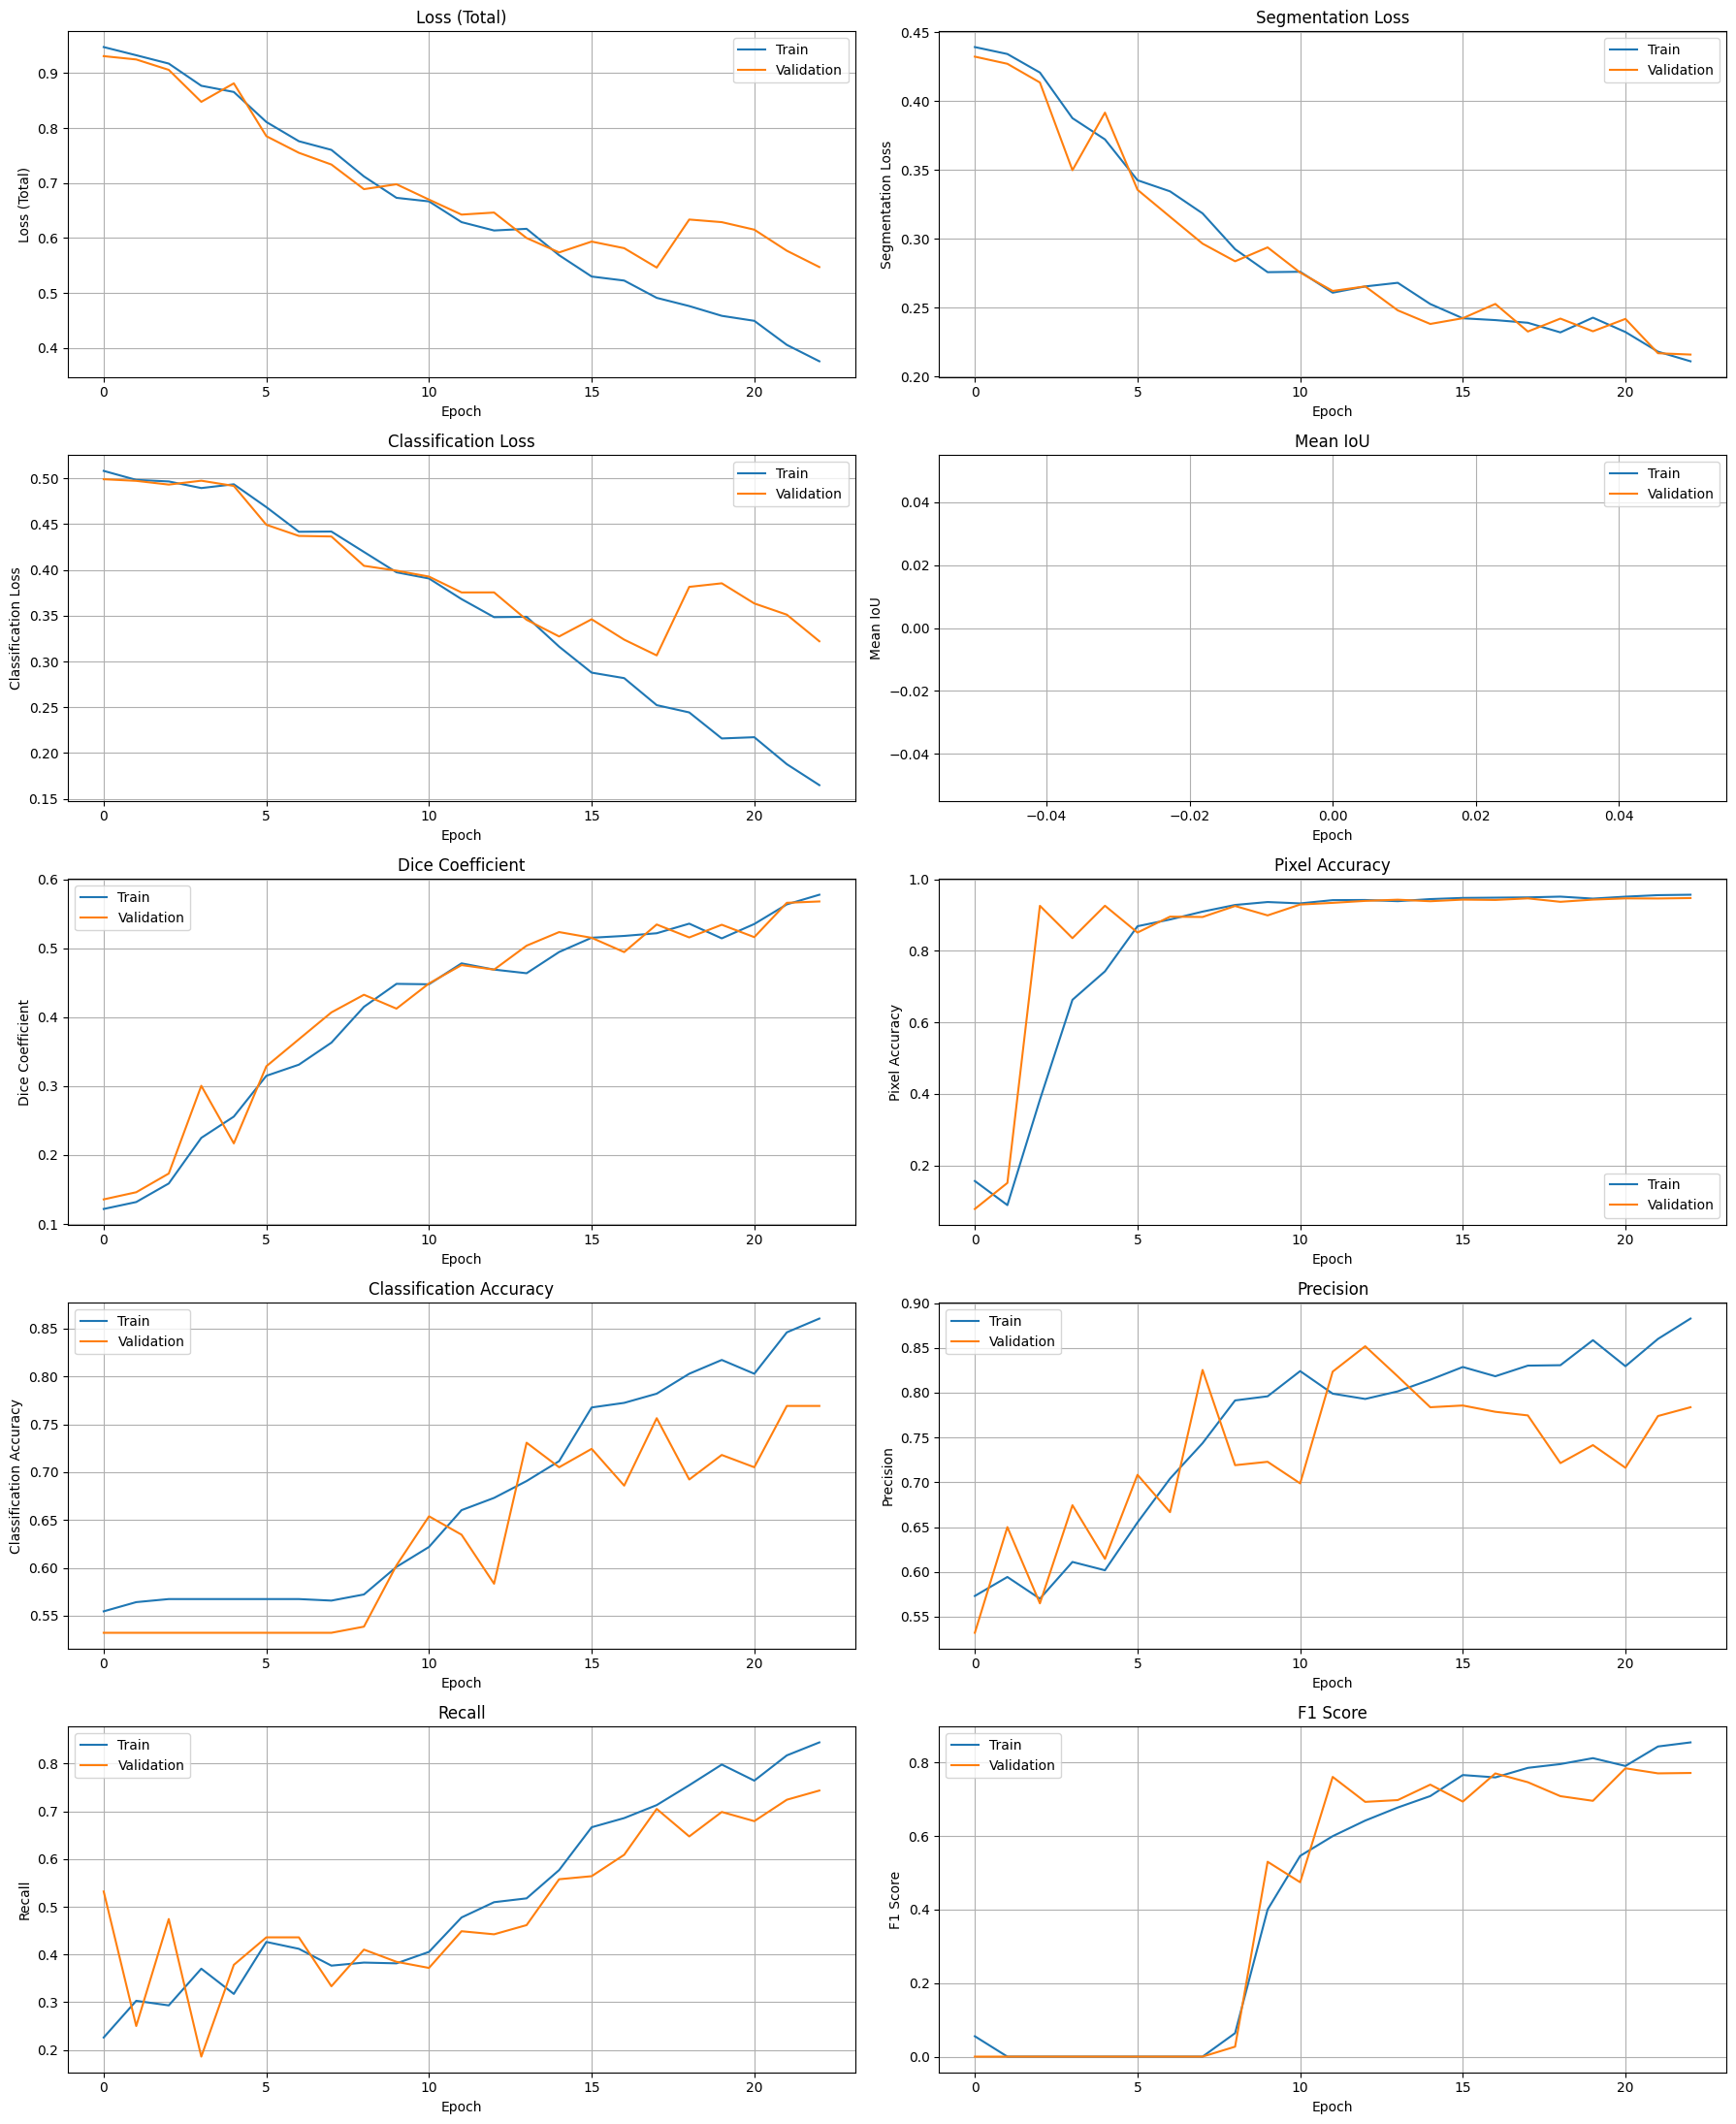

In [26]:
import matplotlib.pyplot as plt

# Define metrics to plot
metrics_to_plot = {
    'Loss (Total)': ('loss', 'val_loss'),
    'Segmentation Loss': ('seg_output_loss', 'val_seg_output_loss'),
    'Classification Loss': ('class_output_loss', 'val_class_output_loss'),
    'Mean IoU': ('seg_output_mean_io_u_3', 'val_seg_output_mean_io_u_3'),
    'Dice Coefficient': ('seg_output_dice_coef', 'val_seg_output_dice_coef'),
    'Pixel Accuracy': ('seg_output_pixel_accuracy', 'val_seg_output_pixel_accuracy'),
    'Classification Accuracy': ('class_output_accuracy', 'val_class_output_accuracy'),
    'Precision': ('class_output_precision', 'val_class_output_precision'),
    'Recall': ('class_output_recall', 'val_class_output_recall'),
    'F1 Score': ('class_output_f1_score', 'val_class_output_f1_score')
}

# Plot
num_metrics = len(metrics_to_plot)
plt.figure(figsize=(18, num_metrics * 2.2))

for idx, (title, (train_key, val_key)) in enumerate(metrics_to_plot.items(), 1):
    plt.subplot((num_metrics + 1) // 2, 2, idx)
    plt.plot(history.history.get(train_key, []), label='Train')
    plt.plot(history.history.get(val_key, []), label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


📊 Classification Report:

              precision    recall  f1-score   support

      normal       0.76      0.87      0.81        83
      benign       0.86      0.62      0.72        50
   malignant       0.60      0.65      0.63        23

    accuracy                           0.76       156
   macro avg       0.74      0.71      0.72       156
weighted avg       0.77      0.76      0.75       156


📌 Average Dice Coefficient:     0.5347
📌 Average Pixel Accuracy:       0.9469
📌 Average Intersection over Union (IoU): 0.4482


/tmp/ipykernel_31/2115827110.py:94: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


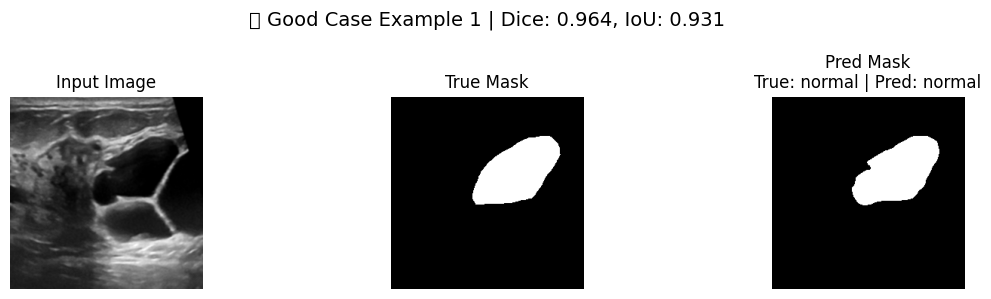

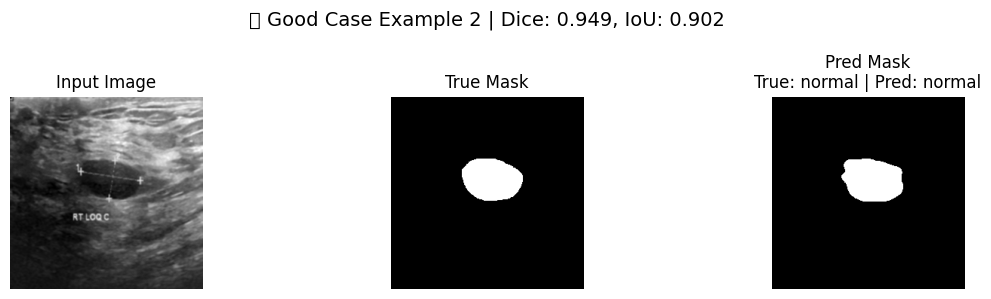

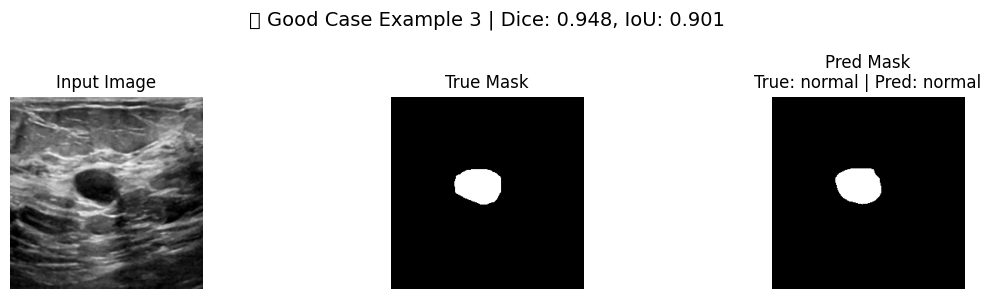

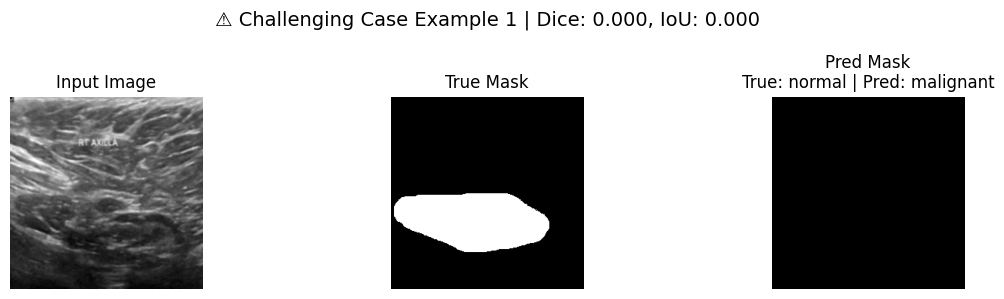

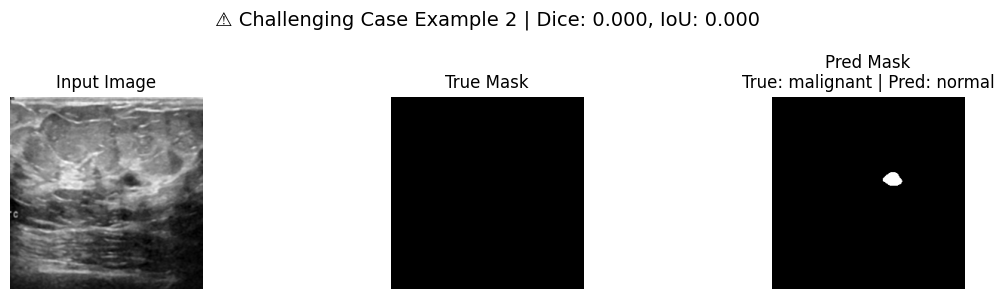

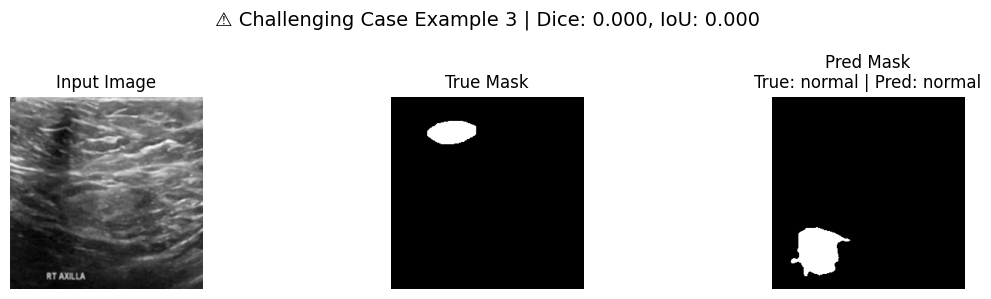

In [13]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_with_examples(model, generator, class_labels=['normal', 'benign', 'malignant'], top_k=3):
    results = []
    all_true_classes = []
    all_pred_classes = []
    all_dice = []
    all_iou = []
    all_pixel_acc = []

    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        preds = model.predict(batch_x, verbose=0)

        # Handle dict or tuple
        if isinstance(preds, dict):
            pred_mask = preds['seg_output']
            pred_class = preds['class_output']
        else:
            pred_mask, pred_class = preds

        true_classes = np.argmax(batch_y['class_output'], axis=1)
        pred_classes = np.argmax(pred_class, axis=1)
        true_masks = (batch_y['seg_output'] > 0.5).astype(np.uint8)
        pred_masks = (pred_mask > 0.5).astype(np.uint8)

        for j in range(len(batch_x)):
            img = batch_x[j].squeeze()
            true_mask = true_masks[j].squeeze()
            pred_mask_bin = pred_masks[j].squeeze()
            true_cls = true_classes[j]
            pred_cls = pred_classes[j]

            intersection = np.logical_and(true_mask, pred_mask_bin).sum()
            union = np.logical_or(true_mask, pred_mask_bin).sum()
            pixel_acc = (true_mask == pred_mask_bin).sum() / np.prod(true_mask.shape)
            dice = (2 * intersection) / (true_mask.sum() + pred_mask_bin.sum() + 1e-6)
            iou = intersection / (union + 1e-6)

            results.append({
                "image": img,
                "true_mask": true_mask,
                "pred_mask": pred_mask_bin,
                "true_cls": true_cls,
                "pred_cls": pred_cls,
                "dice": dice,
                "iou": iou,
                "pixel_acc": pixel_acc
            })

            # Track for overall scores
            all_true_classes.append(true_cls)
            all_pred_classes.append(pred_cls)
            all_dice.append(dice)
            all_iou.append(iou)
            all_pixel_acc.append(pixel_acc)

    # 🎯 Print classification report
    print("📊 Classification Report:\n")
    print(classification_report(all_true_classes, all_pred_classes, target_names=class_labels))

    # 📈 Print average segmentation scores
    print(f"\n📌 Average Dice Coefficient:     {np.mean(all_dice):.4f}")
    print(f"📌 Average Pixel Accuracy:       {np.mean(all_pixel_acc):.4f}")
    print(f"📌 Average Intersection over Union (IoU): {np.mean(all_iou):.4f}")

    # 🔍 Sort by dice
    results_sorted = sorted(results, key=lambda x: x['dice'], reverse=True)
    # print(results_sorted)

    def plot_examples(examples, title_prefix=""):
        for i, res in enumerate(examples):
            plt.figure(figsize=(12, 3))
            plt.suptitle(f"{title_prefix} Example {i+1} | Dice: {res['dice']:.3f}, IoU: {res['iou']:.3f}", fontsize=14)

            plt.subplot(1, 3, 1)
            plt.imshow(res['image'], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(res['true_mask'], cmap='gray')
            plt.title("True Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(res['pred_mask'], cmap='gray')
            true_cls = class_labels[res['true_cls']]
            pred_cls = class_labels[res['pred_cls']]
            plt.title(f"Pred Mask\nTrue: {true_cls} | Pred: {pred_cls}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    # ✅ Plot good examples
    plot_examples(results_sorted[:top_k], title_prefix="✅ Good Case")

    # ⚠️ Plot challenging examples
    plot_examples(results_sorted[-top_k:], title_prefix="⚠️ Challenging Case")


evaluate_model_with_examples(model, val_gen, top_k=3)



# **Live Demo Part**

In [14]:
def preprocess_image(img_path, img_size=IMG_SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
    img = cv2.resize(img, (img_size, img_size))  # Resize to model input size
    img = img.astype(np.float32) / 255.0  # Normalize the pixel values to [0, 1]
    img = np.expand_dims(img, axis=-1)  # Add a channel dimension (for grayscale)
    return np.expand_dims(img, axis=0)  # Add batch dimension for model input

# Example for loading a random image from unseen images
img_path = '/kaggle/input/lab-test/Lab test/02.png'
preprocessed_img = preprocess_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Pred Mask Type: <class 'numpy.ndarray'>
Pred Mask Shape: (1, 256, 256, 1)
Pred Class Type: <class 'numpy.ndarray'>
Pred Class Shape: (1, 3)


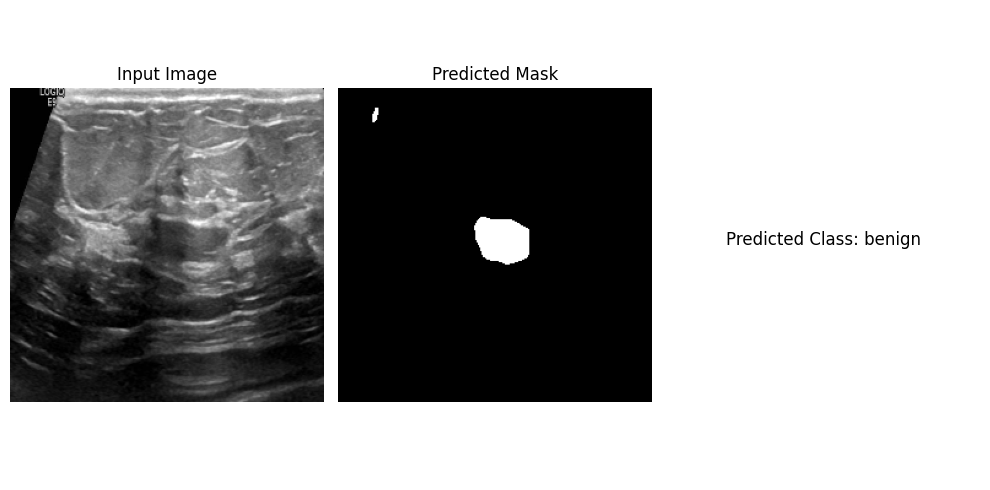

In [15]:
# Predict using the trained model
preds = model.predict(preprocessed_img)

# Handle the case where the model returns a dict (seg_output, class_output)
if isinstance(preds, dict):
    pred_mask = preds['seg_output']  # Segmentation output
    pred_class = preds['class_output']  # Classification output
else:
    print("Unexpected output format for model predictions.")

# Check the type and shape of pred_mask and pred_class
print(f"Pred Mask Type: {type(pred_mask)}")
print(f"Pred Mask Shape: {pred_mask.shape}")
print(f"Pred Class Type: {type(pred_class)}")
print(f"Pred Class Shape: {pred_class.shape}")

# Binarize the segmentation mask if pred_mask is correct
if isinstance(pred_mask, np.ndarray) or isinstance(pred_mask, tf.Tensor):
    pred_mask_bin = (pred_mask.squeeze() > 0.5).astype(np.uint8)  # Binarize mask

    # Plot the results
    plt.figure(figsize=(10, 5))

    # Original Image (grayscale)
    plt.subplot(1, 3, 1)
    plt.imshow(preprocessed_img.squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask_bin, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Predicted Class
    pred_label = np.argmax(pred_class, axis=-1)  # Get the predicted class label
    class_labels = ['normal', 'benign', 'malignant']
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, f"Predicted Class: {class_labels[pred_label[0]]}", fontsize=12, ha='center')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Error: The predicted mask is not the expected format.")
